# LSTM V1

This is a test training an embedding layer, Bidirectional LSTM and one dense layer entirely from scratch starting with random initializations. The performance is suboptimal showing that it makes more sense to use pretrained document embeddings from TensorFlow Hub rather than training an LSTM from scratch. This is mainly due to the limited dataset; with more labeled data, this approach could be used. 

In [1]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing import sequence, text
from tensorflow.keras import models, layers
from LSTM_functions import text_to_seq, plot_history, preprocess_sentence, prediction_table, prediction
from tensorflow.keras.models import load_model 
import warnings
warnings.filterwarnings('ignore')

In [2]:
with open('features.pkl', 'rb') as f:
    features = pickle.load(f)

with open('labels.pkl', 'rb') as f:
    labels = pickle.load(f)
    
X_train_raw, X_test_raw, y_train, y_test = train_test_split(features, labels, test_size = 0.33, random_state=42)

In [3]:
X_train_raw

array(['theirger samsungesignpreviously featuredstylized  white swords on',
       'pole when not applied to childrenay ',
       'found aroundtropicallocations ', ...,
       ' andchinesecabbage likebok choy  as commonly',
       'such as nauseated face appearing as if',
       ' as used in playing classic arcade'], dtype=object)

In [4]:
sequence_length=7
vocab=5000
# use this function to convert the sentences into a sequences of indices 
X_train, X_test, tokenizer = text_to_seq(X_train_raw, X_test_raw, max_length=sequence_length, vocab=vocab)

In [5]:
train_data = tf.data.Dataset.from_tensor_slices((X_train, y_train)).cache()
test_data = tf.data.Dataset.from_tensor_slices((X_test, y_test)).cache()

In [6]:
embedding_size = 100 # we use 100 to compare with the LSTM initializing with glove embeddings (LSTM_v2)
emoji_clusters=12

model = models.Sequential()

model.add(layers.Embedding(
    vocab, 
    embedding_size,
    input_length=sequence_length
))

model.add(layers.Bidirectional(layers.LSTM(32)))
model.add(layers.Dropout(.2))
model.add(layers.Dense(emoji_clusters, activation='softmax', kernel_regularizer='l2'))
model.summary()

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Comment out this section to avoid training from scratch 

history = model.fit(
    train_data.shuffle(100).batch(32),
    epochs=20,
    validation_data = test_data.batch(32)
)

model.save('model_LSTM_1.h5')

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 7, 100)            500000    
_________________________________________________________________
bidirectional (Bidirectional (None, 64)                34048     
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 12)                780       
Total params: 534,828
Trainable params: 534,828
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
247/247 [==============================] - 5s 21ms/step - loss: 2.0958 - accuracy: 0.3403 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/20
247/247 [==============================] - 2s 7ms/step - loss: 1.4443 - accuracy: 0.56

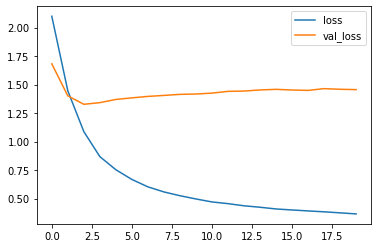

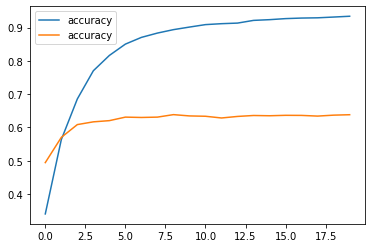

In [7]:
plot_history(model.history)

## Testing the model with custom input

In [8]:
model = load_model('model_LSTM_1.h5')

In [9]:
test_text = "Hot weather and sunshine"
pre_sentence = preprocess_sentence(test_text, tokenizer) # the sentence cannot be two words else it doesn't work
prediction(pre_sentence, model)

'Travel & Places'

In [10]:
prediction_table(pre_sentence, model)

+-----------------+-------------+
|     Category    | Probability |
+-----------------+-------------+
| Travel & Places |    97.82%   |
|    Activities   |    0.49%    |
|    Body_parts   |    0.37%    |
+-----------------+-------------+
